# Time Series

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import os, sys
path_add = os.path.abspath(os.pardir)
if path_add not in sys.path:
    sys.path.append(path_add)

## Agenda

SWBAT:

- Manipulate datetime objects;
- Use rolling and weighted averages to inspect time series;
- Conduct Dickey-Fuller Tests for stationarity.

## Intro

The study of time series has arisen because certain sorts of data streams are heavily dependent on the flow of time. Of course, we have not totally ignored time as a feature up to this point. The selling price of a house probably *does* have some relation to the season or the year as real estate markets grow and decline with certain temporally-indexed economic changes etc. But surely time is not the most important predictor of house price. Square footage would likely be more strongly correlated with price than would date of sale.

But there are other sorts of data that more readily lend themselves to a temporal analysis. One canonical example is numbers from a stock exchange: First, data from stock tickers often arrive as numbers anchored to consecutive units of time. I get the selling price for some stock on January 1, say, and the next bit of information I gain will be the selling price for that stock on January 2. (We'll explore this feature of time series below.) Second, and more important, if I'm interested in actually *predicting* the selling price of a stock for, say, tomorrow, then very likely one piece of very salient (i.e. *correlated*) information would be the selling price of that stock *today*.

Let's look at some time series data plots.

## Visualizing Trends

In [2]:
# Define a function that will help us load and
# clean up a dataset.

def load_trend(trend_name='football', country_code='us'):
    df = pd.read_csv('../data/google-trends_'
                     + trend_name + '_'
                     + country_code
                     + '.csv').iloc[1:, :]
    df.columns = ['counts']
    df['counts'] = df['counts'].str.replace('<1', '0').astype(int)
    return df

In [3]:
df = load_trend(**{'trend_name': 'data-science', 'country_code': 'us'})


In [4]:
trends = [
    {'trend_name': 'data-science', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'uk'},
    {'trend_name': 'coronavirus', 'country_code': 'us'},
    {'trend_name': 'trump', 'country_code': 'us'},
    {'trend_name': 'taxes', 'country_code': 'us'},
    {'trend_name': 'avengers', 'country_code': 'us'}
]

In [5]:
np.random.shuffle(trends)

In [6]:
trend_dfs = [load_trend(**trend) for trend in trends]

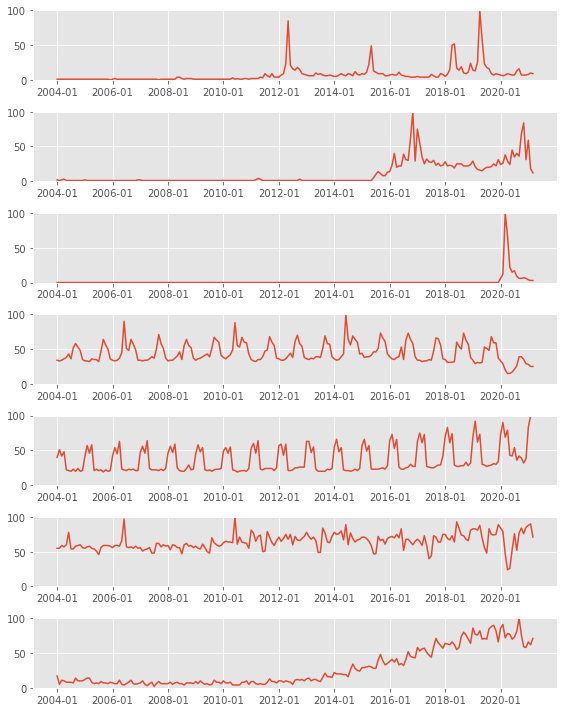

In [7]:
# Let's see if we can guess which is which just by looking
# at their graphs.

fig, axs = plt.subplots(len(trend_dfs), 1, figsize=(8, 10))
plt.tight_layout()
for i, trend_df in enumerate(trend_dfs):
    ax = axs[i]
    #ax.set_title(str(trends[i]))
    ax.plot(np.array(trend_df.index), trend_df['counts'])
    ticks = ax.get_xticks()
    ax.set_ylim((0, 100))
    ax.set_xticks([tick for tick in ticks if tick%24 == 0])

## Series as Both Predictor and Target?

Often, the phenomenon we want to capture with a time series is a dataset being correlated with *itself*.

Well, of course every dataset is perfectly correlated with itself. But what we're after now is the idea that a series is correlated with *earlier versions* of itself.

Consider the problem of trying to predict tomorrow's closing price for some stock on the market. One may consider lots of features, like what sort of company it is to which the stock belongs or whether that company has been in the news recently.

But it is very often the case that one of the most helpful predictors of tomorrow's price is *today's* price. And so we want to build a model where one of our predictors is an earlier version of our target.

## EDA

Let's import some data on **gun violence in Chicago**.

[source](https://data.cityofchicago.org/Public-Safety/Gun-Crimes-Heat-Map/iinq-m3rg)

In [8]:
ts = pd.read_csv('../data/Gun_Crimes_Heat_Map.csv')

In [9]:
ts.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,9446834,HX100098,01/01/2014 12:02:00 AM,072XX S MORGAN ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENTIAL YARD (FRONT/BACK),True,False,...,17.0,68,15,1170897.0,1856795.0,2014,02/10/2018 03:50:01 PM,41.762519,-87.649198,"(41.762519013, -87.64919809)"
1,9446765,HX100013,01/01/2014 12:03:00 AM,064XX S ROCKWELL ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENTIAL YARD (FRONT/BACK),True,False,...,15.0,66,15,1160145.0,1861909.0,2014,02/10/2018 03:50:01 PM,41.776780,-87.688465,"(41.776780469, -87.688465418)"
2,9446921,HX100067,01/01/2014 12:04:00 AM,048XX S PRAIRIE AVE,1460,WEAPONS VIOLATION,POSS FIREARM/AMMO:NO FOID CARD,APARTMENT,True,False,...,3.0,38,15,1178859.0,1872997.0,2014,02/04/2016 06:33:39 AM,41.806801,-87.619523,"(41.806801421, -87.61952336)"
3,9446783,HX100093,01/01/2014 12:05:00 AM,011XX W 50TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,PARKING LOT/GARAGE(NON.RESID.),True,False,...,16.0,61,15,1169689.0,1871646.0,2014,02/10/2018 03:50:01 PM,41.803298,-87.653195,"(41.8032982, -87.653195042)"
4,9446811,HX100017,01/01/2014 12:05:00 AM,031XX W WALNUT ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENCE PORCH/HALLWAY,True,False,...,27.0,27,15,1155344.0,1901461.0,2014,02/10/2018 03:50:01 PM,41.885414,-87.705005,"(41.885413516, -87.705005317)"


Let's look at some summary stats:

In [10]:
print(f"There are {ts.shape[0]} records in our timeseries")

There are 97437 records in our timeseries


In [11]:
# Definitely some messy input of our Desciption data
ts['Description'].value_counts()

AGGRAVATED: HANDGUN                              26221
ARMED: HANDGUN                                   22691
UNLAWFUL POSS OF HANDGUN                         19121
AGGRAVATED - HANDGUN                              7695
UNLAWFUL POSSESSION - HANDGUN                     5205
RECKLESS FIREARM DISCHARGE                        4377
ARMED - HANDGUN                                   2866
UNLAWFUL USE HANDGUN                              2391
ATTEMPT: ARMED-HANDGUN                            1984
AGGRAVATED: OTHER FIREARM                          668
UNLAWFUL USE - HANDGUN                             623
UNLAWFUL POSS OTHER FIREARM                        611
POSS FIREARM/AMMO:NO FOID CARD                     453
UNLAWFUL USE OTHER FIREARM                         405
ATTEMPT ARMED - HANDGUN                            316
ARMED: OTHER FIREARM                               299
AGGRAVATED PO: HANDGUN                             288
UNLAWFUL USE - OTHER FIREARM                       262
AGG PRO.EM

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


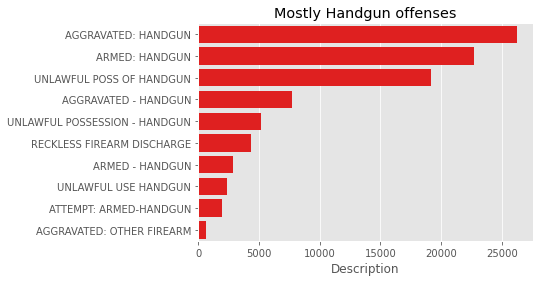

In [12]:
height = ts['Description'].value_counts()[:10]
offense_names = ts['Description'].value_counts()[:10].index

fig, ax = plt.subplots()
sns.barplot(height, offense_names, color='r', ax=ax)
ax.set_title('Mostly Handgun offenses');

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


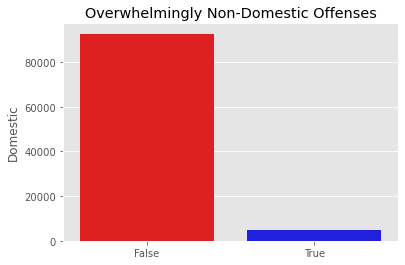

In [13]:
# Mostly non-domestic offenses

fig, ax = plt.subplots()
sns.barplot( ts['Domestic'].value_counts().index, 
             ts['Domestic'].value_counts(),  
             palette=[ 'r', 'b'], ax=ax
           )

ax.set_title("Overwhelmingly Non-Domestic Offenses");

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


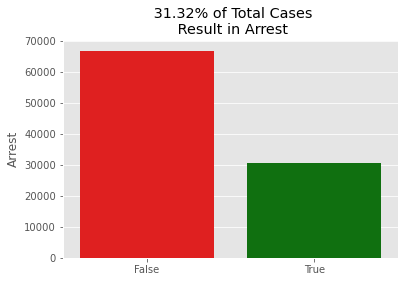

In [14]:
# Mostly non-domestic offenses

arrest_rate = ts['Arrest'].value_counts()[1]/len(ts)

fig, ax = plt.subplots()

sns.barplot( ts['Arrest'].value_counts().index, 
             ts['Arrest'].value_counts(), 
             palette=['r', 'g'], ax=ax
           )

ax.set_title(f'{arrest_rate: 0.2%} of Total Cases\n Result in Arrest');

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


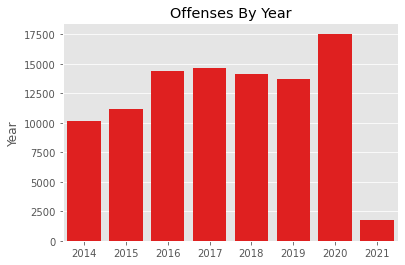

In [15]:
fig, ax = plt.subplots()
sns.barplot( ts['Year'].value_counts().index, 
             ts['Year'].value_counts(),  
             color= 'r', ax=ax
           )

ax.set_title("Offenses By Year");

While this does show some interesting information that will be relevant to our time series analysis, we are going to get more granular.

## Datetime Objects

Datetime objects make our time series modeling lives easier.  They will allow us to perform essential data prep tasks with a few lines of code.  

We need our timeseries **index** to be datetime objects, since our models will rely on being able to identify the previous chronological value.

There is a `datetime` [library](https://docs.python.org/2/library/datetime.html), and inside `pandas` there is a datetime module as well as a to_datetime() function.

For time series modeling, the first step often is to make sure that the index is a datetime object.

There are a few ways to **reindex** our series to datetime. 

We can use `pandas.to_datetime()` method:

In [16]:
ts.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,9446834,HX100098,01/01/2014 12:02:00 AM,072XX S MORGAN ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENTIAL YARD (FRONT/BACK),True,False,...,17.0,68,15,1170897.0,1856795.0,2014,02/10/2018 03:50:01 PM,41.762519,-87.649198,"(41.762519013, -87.64919809)"


In [17]:
ts.index

RangeIndex(start=0, stop=97437, step=1)

In [18]:
ts.set_index(pd.to_datetime(ts['Date']), drop=True, inplace=True)

Or, we can parse the dates directly on import:

In [19]:
ts = pd.read_csv('../data/Gun_Crimes_Heat_Map.csv', index_col='Date', parse_dates=True)

In [20]:
print(f"Now our index is a {type(ts.index)}")

Now our index is a <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [21]:
ts.head()

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:02:00,9446834,HX100098,072XX S MORGAN ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENTIAL YARD (FRONT/BACK),True,False,733,...,17.0,68,15,1170897.0,1856795.0,2014,02/10/2018 03:50:01 PM,41.762519,-87.649198,"(41.762519013, -87.64919809)"
2014-01-01 00:03:00,9446765,HX100013,064XX S ROCKWELL ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENTIAL YARD (FRONT/BACK),True,False,825,...,15.0,66,15,1160145.0,1861909.0,2014,02/10/2018 03:50:01 PM,41.776780,-87.688465,"(41.776780469, -87.688465418)"
2014-01-01 00:04:00,9446921,HX100067,048XX S PRAIRIE AVE,1460,WEAPONS VIOLATION,POSS FIREARM/AMMO:NO FOID CARD,APARTMENT,True,False,224,...,3.0,38,15,1178859.0,1872997.0,2014,02/04/2016 06:33:39 AM,41.806801,-87.619523,"(41.806801421, -87.61952336)"
2014-01-01 00:05:00,9446783,HX100093,011XX W 50TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,PARKING LOT/GARAGE(NON.RESID.),True,False,933,...,16.0,61,15,1169689.0,1871646.0,2014,02/10/2018 03:50:01 PM,41.803298,-87.653195,"(41.8032982, -87.653195042)"
2014-01-01 00:05:00,9446811,HX100017,031XX W WALNUT ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENCE PORCH/HALLWAY,True,False,1222,...,27.0,27,15,1155344.0,1901461.0,2014,02/10/2018 03:50:01 PM,41.885414,-87.705005,"(41.885413516, -87.705005317)"


Datetime objects include aspects of the date as attributes, like month and year:

In [22]:
ts.index[0]

Timestamp('2014-01-01 00:02:00')

In [23]:
ts.index[0].month

1

In [24]:
ts.index[0].year

2014

We can easily see now whether offenses happen, for example, during business hours.

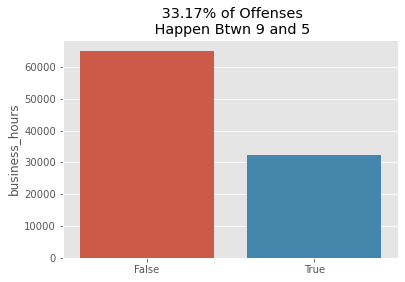

In [25]:
fig, ax = plt.subplots()

ts['hour'] = ts.index
ts['hour'] = ts.hour.apply(lambda x: x.hour)
ts['business_hours'] = ts.hour.apply(lambda x: 9 <= x <= 17)

bh_ratio = ts.business_hours.value_counts()[1]/len(ts)

x = ts.business_hours.value_counts().index
y = ts.business_hours.value_counts()
sns.barplot(x=x, y=y)

ax.set_title(f'{bh_ratio: 0.2%} of Offenses\n Happen Btwn 9 and 5');

## Upsampling and Downsampling

With a Datetime index, we also have new abilities, such as **resampling**.

To create our timeseries, we will count the number of gun offenses reported per day.

In [26]:
ts.resample('D')

There are many possible units for resampling, each with its own alias:

<table style="display: inline-block">
    <caption style="text-align: center"><strong>TIME SERIES OFFSET ALIASES</strong></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>B</td><td>business day frequency</td></tr>
<tr><td>C</td><td>custom business day frequency (experimental)</td></tr>
<tr><td>D</td><td>calendar day frequency</td></tr>
<tr><td>W</td><td>weekly frequency</td></tr>
<tr><td>M</td><td>month end frequency</td></tr>
<tr><td>SM</td><td>semi-month end frequency (15th and end of month)</td></tr>
<tr><td>BM</td><td>business month end frequency</td></tr>
<tr><td>CBM</td><td>custom business month end frequency</td></tr>
<tr><td>MS</td><td>month start frequency</td></tr>
<tr><td>SMS</td><td>semi-month start frequency (1st and 15th)</td></tr>
<tr><td>BMS</td><td>business month start frequency</td></tr>
<tr><td>CBMS</td><td>custom business month start frequency</td></tr>
<tr><td>Q</td><td>quarter end frequency</td></tr>
<tr><td></td><td><font color=white>intentionally left blank</font></td></tr></table>

<table style="display: inline-block; margin-left: 40px">
<caption style="text-align: center"></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>BQ</td><td>business quarter endfrequency</td></tr>
<tr><td>QS</td><td>quarter start frequency</td></tr>
<tr><td>BQS</td><td>business quarter start frequency</td></tr>
<tr><td>A</td><td>year end frequency</td></tr>
<tr><td>BA</td><td>business year end frequency</td></tr>
<tr><td>AS</td><td>year start frequency</td></tr>
<tr><td>BAS</td><td>business year start frequency</td></tr>
<tr><td>BH</td><td>business hour frequency</td></tr>
<tr><td>H</td><td>hourly frequency</td></tr>
<tr><td>T, min</td><td>minutely frequency</td></tr>
<tr><td>S</td><td>secondly frequency</td></tr>
<tr><td>L, ms</td><td>milliseconds</td></tr>
<tr><td>U, us</td><td>microseconds</td></tr>
<tr><td>N</td><td>nanoseconds</td></tr></table>

When resampling, we have to provide a rule to resample by, and an **aggregate function**.

**To upsample** is to increase the frequency of the data of interest.  
**To downsample** is to decrease the frequency of the data of interest.

For our purposes, we will downsample, and  count the number of occurences per day.

In [27]:
ts.resample('D').count()

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,hour,business_hours
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
2014-01-02,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
2014-01-03,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
2014-01-04,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
2014-01-05,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-07,34,34,34,34,34,34,34,34,34,34,...,34,33,33,34,34,33,33,33,34,34
2021-02-08,30,30,30,30,30,30,30,30,30,30,...,30,26,26,30,30,26,26,26,30,30
2021-02-09,38,38,38,38,38,38,38,38,38,38,...,38,19,19,38,38,19,19,19,38,38


Our time series will consist of a series of counts of gun reports per day.

In [28]:
# ID is unimportant. We could choose any column, since the counts are the same.
ts = ts.resample('D').count()['ID']

In [29]:
ts

Date
2014-01-01    50
2014-01-02    33
2014-01-03    24
2014-01-04    32
2014-01-05    17
              ..
2021-02-07    34
2021-02-08    30
2021-02-09    38
2021-02-10    34
2021-02-11    29
Freq: D, Name: ID, Length: 2599, dtype: int64

Let's visualize our timeseries with a plot.

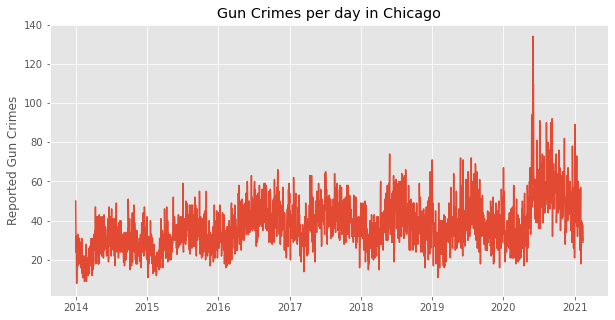

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts.index, ts.values)
ax.set_title('Gun Crimes per day in Chicago')
ax.set_ylabel('Reported Gun Crimes');

There seems to be some abnormal activity happening towards the end of our series.

**[sun-times](https://chicago.suntimes.com/crime/2020/6/8/21281998/chicago-deadliest-day-violence-murder-history-police-crime)**

In [31]:
ts.sort_values(ascending=False)[:10]

Date
2020-05-31    134
2020-06-02    110
2020-06-01     99
2020-06-03     94
2020-05-25     94
2020-09-06     92
2020-07-05     91
2020-08-08     90
2020-08-30     90
2021-01-01     89
Name: ID, dtype: int64

Let's treat the span of days from 5-31 to 6-03 as outliers. 

There are several ways to do this, but let's first remove the outliers, and populate an an empty array with the original date range. That will introduce us to the `pandas.date_range()` method.

In [32]:
daily_count = ts[ts < 90]
ts_dr = pd.date_range(daily_count.index[0], daily_count.index[-1])
ts_daily = np.empty(shape=len(ts_dr))
ts_daily = pd.Series(ts_daily)
ts_daily = ts_daily.reindex(ts_dr)
ts = ts_daily.fillna(daily_count)

In [33]:
ts

2014-01-01    50.0
2014-01-02    33.0
2014-01-03    24.0
2014-01-04    32.0
2014-01-05    17.0
              ... 
2021-02-07    34.0
2021-02-08    30.0
2021-02-09    38.0
2021-02-10    34.0
2021-02-11    29.0
Freq: D, Length: 2599, dtype: float64

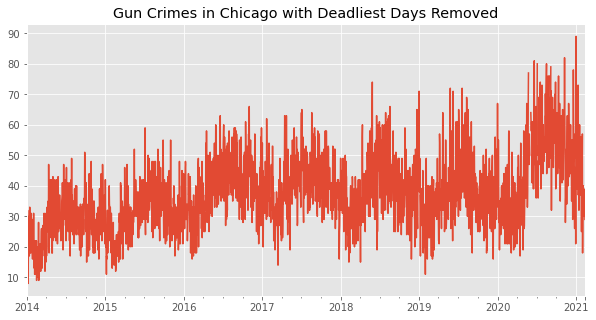

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ts.plot(ax=ax)
ax.set_title('Gun Crimes in Chicago with Deadliest Days Removed');

Let's zoom in on that week again:

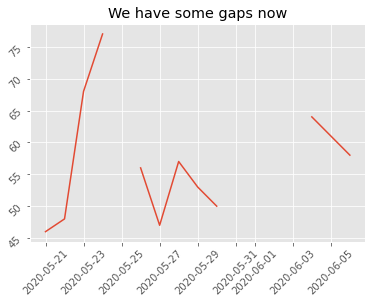

In [35]:
fig, ax = plt.subplots()
ax.plot(ts[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')]
       )
ax.tick_params(rotation=45)
ax.set_title('We have some gaps now');

The datetime object allows us several options of how to fill those gaps:

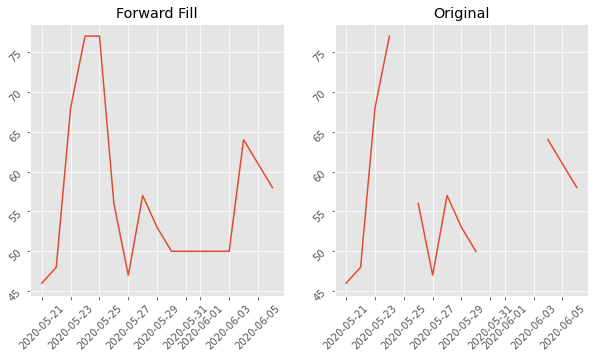

In [36]:
# .ffill()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(ts.ffill()[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')]
       )
ax1.tick_params(rotation=45)
ax1.set_title('Forward Fill')

ax2.plot(ts[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')]
       )
ax2.tick_params(rotation=45)
ax2.set_title('Original');

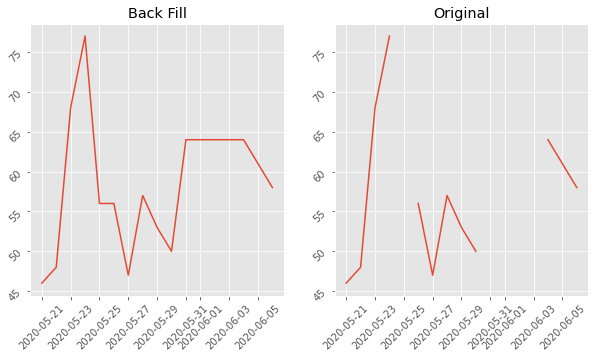

In [37]:
# .bfill()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(ts.bfill()[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')]
       )
ax1.tick_params(rotation=45)
ax1.set_title('Back Fill')

ax2.plot(ts[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')]
       )
ax2.tick_params(rotation=45)
ax2.set_title('Original');

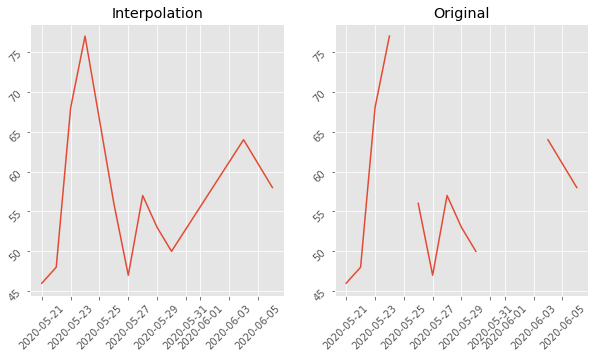

In [38]:
# .interpolate()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(ts.interpolate()[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')]
       )
ax1.tick_params(rotation=45)
ax1.set_title('Interpolation')

ax2.plot(ts[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')]
       )
ax2.tick_params(rotation=45)
ax2.set_title('Original');

Let's proceed with the interpolated data.

In [39]:
ts = ts.interpolate()
ts.isna().sum()

0

Now that we've cleaned up a few data points, let's downsample to the week level.  

In [40]:
ts_weekly = ts.resample('W').mean()

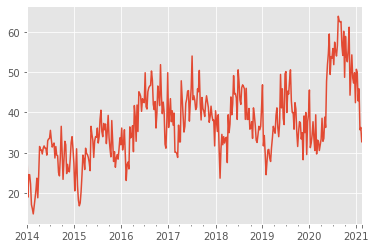

In [41]:
ts_weekly.plot();

## Visual Diagnostics with Moving Averages

Let's begin considering some models for our data.

These are not useful for prediction just yet, but they will lead us towards our prediction models.

### Simple Moving Average

A simple moving average consists of an average across a specified window of time. 

The datetime index allows us to calculate simple moving averages via the `rolling()` function.

The rolling function calculates a statistic across a moving **window**, which we can change with the window parameter.

In [42]:
ts_weekly.rolling(window=4)

Rolling [window=4,center=False,axis=0]

Let's calculate a month long moving average

In [43]:
ts_weekly.rolling(4).mean()[:10]

2014-01-05          NaN
2014-01-12          NaN
2014-01-19          NaN
2014-01-26    24.835714
2014-02-02    22.607143
2014-02-09    22.142857
2014-02-16    20.035714
2014-02-23    17.607143
2014-03-02    16.214286
2014-03-09    16.607143
Freq: W-SUN, dtype: float64

This is simply the average of a datapoint and the previous three data points:

In [44]:
ts_weekly[:4]

2014-01-05    31.200000
2014-01-12    19.000000
2014-01-19    24.571429
2014-01-26    24.571429
Freq: W-SUN, dtype: float64

In [45]:
ts_weekly[:4].mean() 

24.835714285714285

In [46]:
ts_weekly[:4].mean() == ts_weekly.rolling(4).mean()[3]

True

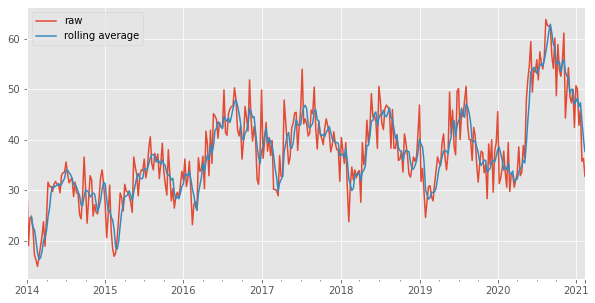

In [47]:
sma_week = ts_weekly.rolling(4).mean()

fig, ax = plt.subplots(figsize=(10, 5))

ts_weekly.plot(ax=ax, label='raw')
sma_week.plot(ax=ax, label='rolling average')

plt.legend();

As we can see from the plot below, the simple moving average **smooths** out the series. Smoothing can help visualize the underlying pattern. It can also be a very simple predictive model, where we just project the mean out into the future.

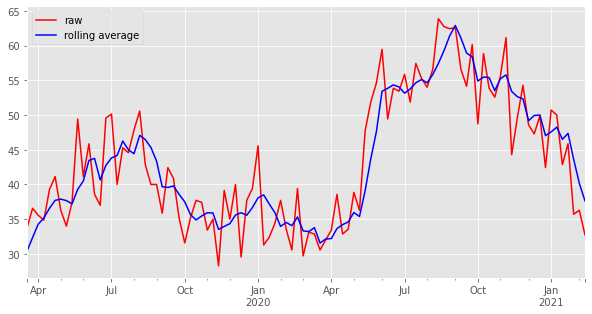

In [48]:
# Let's zoom in

fig, ax = plt.subplots(figsize=(10,5))

ts_weekly[-100:].plot(ax=ax, c='r', label='raw')
sma_week[-100:].plot(ax=ax, c='b', label='rolling average')

plt.legend();

The simple moving avereage tracks fairly well, but does not reach to the peaks and valleys of the original distribution.

If we plot the moving average across 52 weeeks, we can see a smooth trend across a year.

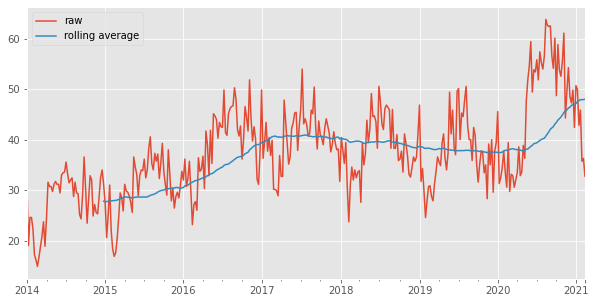

In [49]:
sma_week = ts_weekly.rolling(52).mean()

fig, ax = plt.subplots(figsize=(10, 5))

ts_weekly.plot(ax=ax, label='raw')
sma_week.plot(ax=ax, label='rolling average')

plt.legend();

### Exponentially Weighted Moving Average 

An alternative to SMA is the [EWMA](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average). The exponentially weighted average gives more weight to the points closer to the date in question.  With EWMA, the average will track more closely to the peaks and valleys. If there are extreme historical values in the dataset, the EWMA will be less skewed than the SMA.

In [50]:
ts_ex_ewm = ts_weekly.ewm(alpha=0.5).mean()[:10]
ts_ex_ewm

2014-01-05    31.200000
2014-01-12    23.066667
2014-01-19    23.926531
2014-01-26    24.270476
2014-02-02    23.246083
2014-02-09    20.146032
2014-02-16    18.128684
2014-02-23    16.486499
2014-03-02    16.600615
2014-03-09    17.658483
Freq: W-SUN, dtype: float64

The higher the $\alpha$ parameter, the closer the EWMA will be to the actual value of the point.

In [51]:
ts_ex_ewm = ts_weekly.ewm(alpha=0.99).mean()[:10]
ts_ex_ewm

2014-01-05    31.200000
2014-01-12    19.120792
2014-01-19    24.516928
2014-01-26    24.570884
2014-02-02    22.308566
2014-02-09    17.194514
2014-02-16    16.153374
2014-02-23    14.870105
2014-03-02    16.695844
2014-03-09    18.694101
Freq: W-SUN, dtype: float64

In [52]:
ts_weekly[:10]

2014-01-05    31.200000
2014-01-12    19.000000
2014-01-19    24.571429
2014-01-26    24.571429
2014-02-02    22.285714
2014-02-09    17.142857
2014-02-16    16.142857
2014-02-23    14.857143
2014-03-02    16.714286
2014-03-09    18.714286
Freq: W-SUN, dtype: float64

Let's plot our rolling statistics with some different windows:

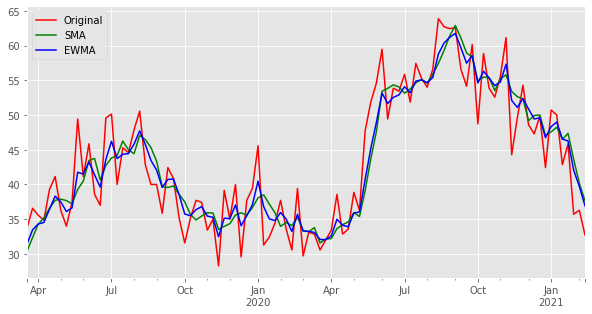

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))

ts_weekly[-100:].plot(ax=ax, c='r', label='Original')
ts_weekly.rolling(4).mean().dropna()[-100:].plot(ax=ax, c='g', label='SMA')
ts_weekly.ewm(span=4).mean().dropna()[-100:].plot(ax=ax, c='b', label='EWMA')

plt.legend();

Again, if we zoom in to the year level, we can see peaks and valleys according to the seasons.  

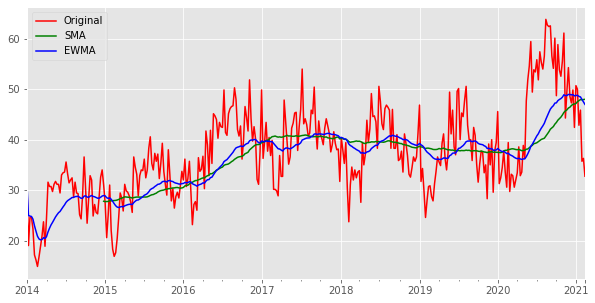

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))

ts_weekly.plot(ax=ax, c='r', label='Original')
ts_weekly.rolling(52).mean().dropna().plot(ax=ax, c='g', label='SMA')
ts_weekly.ewm(span=52).mean().dropna().plot(ax=ax, c='b', label='EWMA')

plt.legend();

We can also plot rolling averages for the variance and standard deviation.

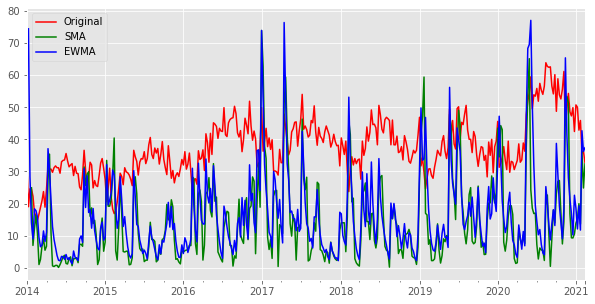

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))

ts_weekly.plot(ax=ax, c='r', label='Original')
ts_weekly.rolling(4).var().dropna().plot(ax=ax, c='g', label='SMA')
ts_weekly.ewm(span=4).var().dropna().plot(ax=ax, c='b', label='EWMA')

plt.legend();

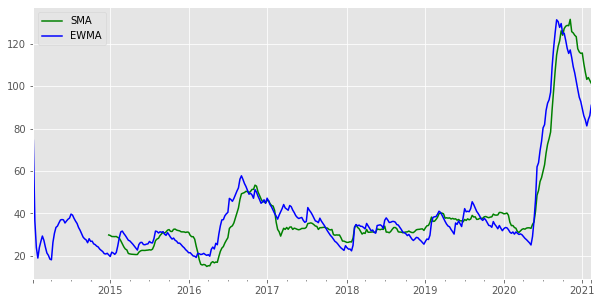

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))

ts_weekly.rolling(52).var().dropna().plot(ax=ax, c='g', label='SMA')
ts_weekly.ewm(span=52).var().dropna().plot(ax=ax, c='b', label='EWMA')

plt.legend();

If we zoom in on our standard deviation, we can see that the variance of our data has quite a fluctuation at different moments in time.  When we are building our models, we will want to remove this variability, or our models will have different performance at different times.

## Components of Time Series Data

A time series in general is supposed to be affected by four main components, which can be separated from the observed data. These components are: *Trend, Cyclical, Seasonal and Irregular* components.

- **Trend** : The long term movement of a time series. For example, series relating to population growth, number of houses in a city etc. show upward trend.
- **Seasonality** : Fluctuation in the data set that follow a regular pattern due to outside influences. For example sales of ice-cream increase in summer, or daily web traffic.
- **Cyclical** : When data exhibit rises and falls that are not of fixed period.  Think of business cycles which usually last several years, but where the length of the current cycle is unknown beforehand.
- **Irregular**: Are caused by unpredictable influences, which are not regular and also do not repeat in a particular pattern. These variations are caused by incidences such as war, strike, earthquake, flood, revolution, etc. There is no defined statistical technique for measuring random fluctuations in a time series.


*Note: Many people confuse cyclic behaviour with seasonal behaviour, but they are really quite different. If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal.*

The statsmodels seasonal decompose can also help show us the trends in our data.

<Figure size 432x288 with 0 Axes>

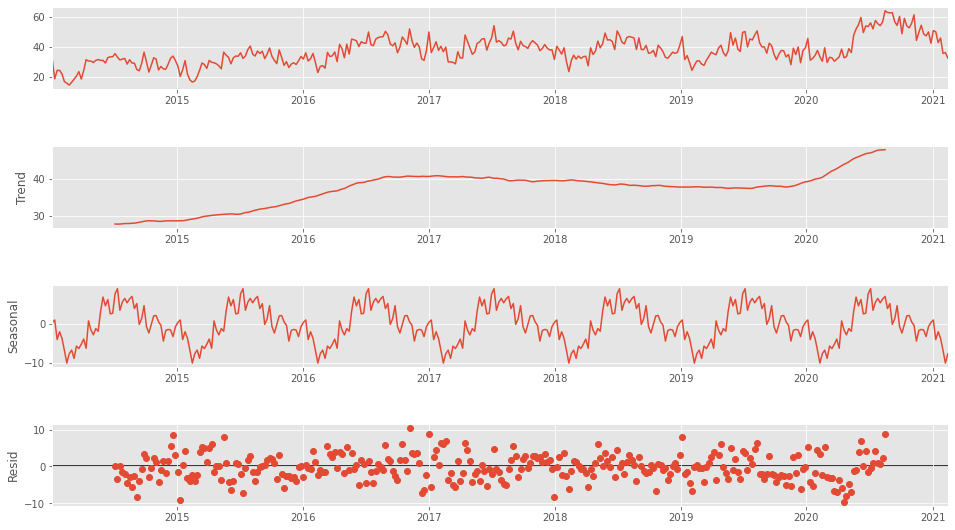

In [57]:
decomposition = seasonal_decompose(ts_weekly)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

## Statistical stationarity: 

When building our models, we will want to account for these trends somehow.  Time series whose mean and variance have trends across time will be difficult to predict out into the future. 

A **stationary time series** is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!

It may seem counterintuitive that, for modeling purposes, we want our time series not to be a function of time! But the basic idea is the familiar one that we want our datapoints to be mutually *independent*. For more on this topic, see [here](https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary).

One way of testing for stationarity is to use the Dickey-Fuller Test. The statsmodels version returns the test statistic and a p-value, relative to the null hypothesis that the series in question is NOT stationary. For more, see [this Wikipedia page](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).


<h3 style="text-align: center;">Constant Mean</p>



<img src='../img/mean_nonstationary.webp'/>

<h3 style="text-align: center;">Constant Variance</p>


<img src='../img/variance_nonstationary.webp'/>

<h3 style="text-align: center;">Constant Covariance</p>


<img src='../img/covariance_nonstationary.webp'/>

While we can get a sense of how stationary our data is with visuals, the Dickey-Fuller test gives us a quantitatitive measure.

Here the null hypothesis is that the TS is non-stationary. If the test statistic is less than the critical value, we can reject the null hypothesis and say that the series is stationary.

In [58]:
#create a function that will help us to quickly test stationarity
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value', '#Lags Used',
                                             'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

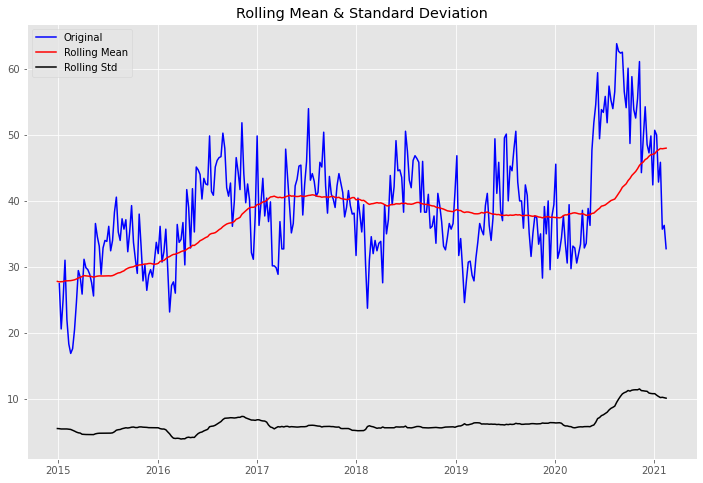

Results of Dickey-Fuller Test:
Test Statistic                  -2.851535
p-value                          0.051281
#Lags Used                       4.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64


In [59]:
test_stationarity(ts_weekly, 52)

The time series does not pass the test of stationarity for $\alpha=0.05$.

### How to stationarize time series data

A series of steps can be taken to stationarize your data - also known -  as removing trends (linear trends, seasonaility/periodicity, etc - more details on transformations <a href='http://people.duke.edu/~rnau/whatuse.htm'>here</a>).


One way to remove trends is to difference our data.  
Differencing is performed by subtracting the previous observation (lag=1) from the current observation.

In [60]:
ts_weekly.diff().dropna()[:5]

2014-01-12   -12.200000
2014-01-19     5.571429
2014-01-26     0.000000
2014-02-02    -2.285714
2014-02-09    -5.142857
Freq: W-SUN, dtype: float64

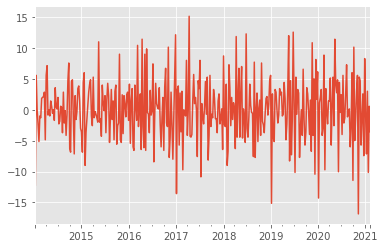

In [61]:
ts_weekly.diff().dropna().plot();

In [62]:
ts_weekly[:5]

2014-01-05    31.200000
2014-01-12    19.000000
2014-01-19    24.571429
2014-01-26    24.571429
2014-02-02    22.285714
Freq: W-SUN, dtype: float64

Sometimes, we have to difference the differenced data (known as a second difference) to achieve stationary data. <b>The number of times we have to difference our data is the order of differencing</b> - we will use this information when building our model.

In [63]:
#Second order difference:

ts_weekly.diff().diff().dropna()[:5]

2014-01-19    17.771429
2014-01-26    -5.571429
2014-02-02    -2.285714
2014-02-09    -2.857143
2014-02-16     4.142857
Freq: W-SUN, dtype: float64

In [64]:
# We can also apply seasonal differences:
    
ts_weekly.diff(52).dropna()[:10]

2015-01-04   -3.771429
2015-01-11    1.571429
2015-01-18    0.428571
2015-01-25    6.428571
2015-02-01   -0.285714
2015-02-08    1.142857
2015-02-15    0.714286
2015-02-22    2.714286
2015-03-01    3.714286
2015-03-08    5.857143
Freq: W-SUN, dtype: float64

Let's difference our data and see if it improves Dickey-Fuller Test

In [65]:
ts_weekly.diff().dropna()

2014-01-12   -12.200000
2014-01-19     5.571429
2014-01-26     0.000000
2014-02-02    -2.285714
2014-02-09    -5.142857
2014-02-16    -1.000000
2014-02-23    -1.285714
2014-03-02     1.857143
2014-03-09     2.000000
2014-03-16     2.142857
2014-03-23     2.857143
2014-03-30    -4.857143
2014-04-06     5.571429
2014-04-13     7.142857
2014-04-20    -0.857143
2014-04-27     0.000000
2014-05-04    -1.000000
2014-05-11     1.428571
2014-05-18     0.571429
2014-05-25    -0.571429
2014-06-01     0.000000
2014-06-08    -1.714286
2014-06-15     3.571429
2014-06-22     0.428571
2014-06-29     0.142857
2014-07-06     2.000000
2014-07-13    -2.285714
2014-07-20    -1.857143
2014-07-27     0.571429
2014-08-03     0.428571
2014-08-10    -3.714286
2014-08-17     2.857143
2014-08-24    -2.142857
2014-08-31    -0.142857
2014-09-07    -4.142857
2014-09-14    -0.857143
2014-09-21     4.714286
2014-09-28     7.571429
2014-10-05    -6.285714
2014-10-12    -6.857143
2014-10-19     4.571429
2014-10-26     4

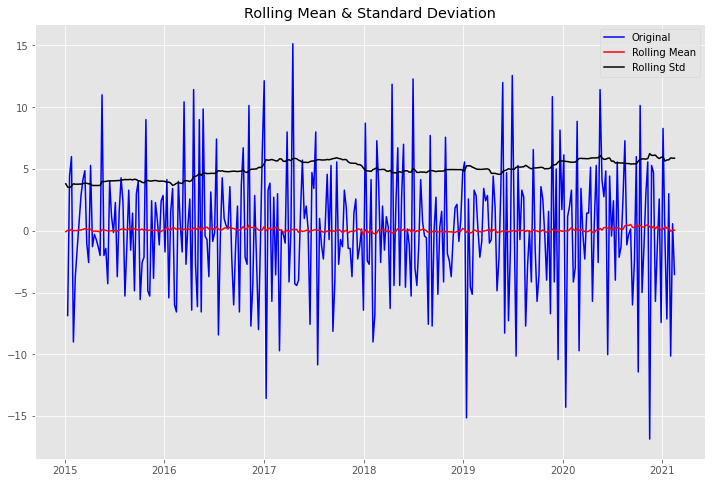

Results of Dickey-Fuller Test:
Test Statistic                -1.324511e+01
p-value                        9.007107e-25
#Lags Used                     3.000000e+00
Number of Observations Used    3.670000e+02
Critical Value (1%)           -3.448294e+00
Critical Value (5%)           -2.869448e+00
Critical Value (10%)          -2.570983e+00
dtype: float64


In [66]:
test_stationarity(ts_weekly.diff().dropna(), 52)

Much better!